# Module 1: Generative Models in Gen

## Outline

**Section 1.** [Julia, Gen, and this Jupyter notebook](#julia-gen-jupyter)

**Section 2.** [Writing a probabilistic model as a generative function](#writing-model)

**Section 3.** [Doing posterior inference](#doing-inference)

**Section 4.** [Predicting new data](#predicting-data)

## 1. Julia, Gen, and this Jupyter notebook  <a name="julia-gen-jupyter"></a>

Gen is a package for the Julia language. The package can be loaded with:

In [1]:
using Gen

Gen programs typically consist of a combination of (i) probabilistic models written in modeling languages and (ii) inference programs written in regular Julia code. Gen provides a built-in modeling language that is itself based on Julia.

In [4]:
using PyPlot

This notebook will make use of Julia symbols. Note that a Julia symbol is different from a Julia string:

In [5]:
typeof(:foo)

Symbol

In [6]:
typeof("foo")

String

## 2. Writing a probabilistic model as a generative function  <a name="writing-model"></a>

Probabilistic models are represented in Gen as *generative functions*. In order for Gen to interpret Julia code as a generative model, we need to prefix the function with the `@gen` keyword.

One of the most important things in Gen is the ***trace* data structure**. The trace stores all the random choices made by the generative model which is extremely useful when we are doing inference.

To include a certain random choice in the generative model we need to add `@trace` keyword with a unique address. In the particular case below, addresses are Julia symbols (e.g. `:slope`) and tuples of symbols and integers (`(:y, i)`).

In [7]:
@gen function line_model(xs::Vector{Float64})
    n = length(xs)
    
    # We begin by sampling a slope and intercept for the line from the prior.
    slope = @trace(normal(0, 1), :slope)
    intercept = @trace(normal(0, 2), :intercept)
    
    # Given the slope and intercept, we can sample y coordinates
    # for each of the x coordinates in our input vector.
    for (i, x) in enumerate(xs)
        @trace(normal(slope * x + intercept, 0.1), (:y, i))
    end
    
    # Return value is often not particularly important.
    return n
end;

![Line Model](images/line_1.png)

In [50]:
xs = [-5., -4., -3., -2., -1., 0., 1., 2., 3., 4., 5.];

Random choices are included in the *execution trace* of the generative function. We can run the generative function and obtain its trace using the [`
simulate`](https://probcomp.github.io/Gen/dev/ref/gfi/#Gen.simulate) method from the Gen API:

In [58]:
trace = Gen.simulate(line_model, (xs,));

This method takes the function to be executed, and a tuple of arguments to the function, and returns a trace and a second value that we will not be using in this tutorial.

Among other things, the trace contains the value of the random choices, stored in map from address to value called a *choice map*. This map is available through the API method [`get_choices`]():

In [59]:
println(Gen.get_choices(trace))

│
├── (:y, 7) : -3.3277184865104097
│
├── (:y, 9) : -4.764625833931291
│
├── (:y, 1) : 1.7091866593576213
│
├── (:y, 10) : -5.541455793857878
│
├── (:y, 5) : -1.7644581089185878
│
├── (:y, 4) : -0.7041320165633312
│
├── :intercept : -2.4029463006484097
│
├── (:y, 3) : -0.18500504718351268
│
├── (:y, 6) : -2.390428616251373
│
├── (:y, 8) : -3.8757299960707807
│
├── (:y, 11) : -6.2537753193140055
│
├── (:y, 2) : 0.7941142479948609
│
└── :slope : -0.7792098623604076



We can pull out individual values from this map using Julia's subscripting syntax `[...]`:

In [60]:
choices = Gen.get_choices(trace)
println(choices[:slope])

-0.7792098623604076


We can also read the value of a random choice directly from the trace, without having to use `get_choices` first:

In [61]:
println(trace[:slope])

-0.7792098623604076


It is helpful to visualize traces of generative functions. The function below renders the x-y data points and the line that is represented by the slope and intercept choices.

In [62]:
function render_trace(trace; show_data=true)
    
    # Pull out xs from the trace
    xs = get_args(trace)[1]
    
    xmin = minimum(xs)
    xmax = maximum(xs)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        
        # Plot the data set
        scatter(xs, ys, c="black")
    end
    
    # Pull out slope and intercept from the trace
    slope = trace[:slope]
    intercept = trace[:intercept]
    
    # Draw the line
    plot([xmin, xmax], slope *  [xmin, xmax] .+ intercept, color="black", alpha=0.5)
    ax = gca()
    ax[:set_xlim]((xmin, xmax))
    ax[:set_ylim]((xmin, xmax))
end;

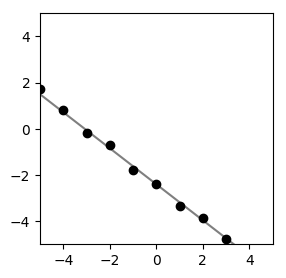

In [64]:
figure(figsize=(3,3))
render_trace(trace);

Because a generative function is stochastic, we need to visualize many runs in order to understand its behavior. The cell below renders a grid of traces.

In [65]:
function grid(renderer::Function, traces; ncols=6, nrows=3)
    figure(figsize=(16, 8))
    for (i, trace) in enumerate(traces)
        subplot(nrows, ncols, i)
        renderer(trace)
    end
end;

Now, we generate several traces and render them in a grid

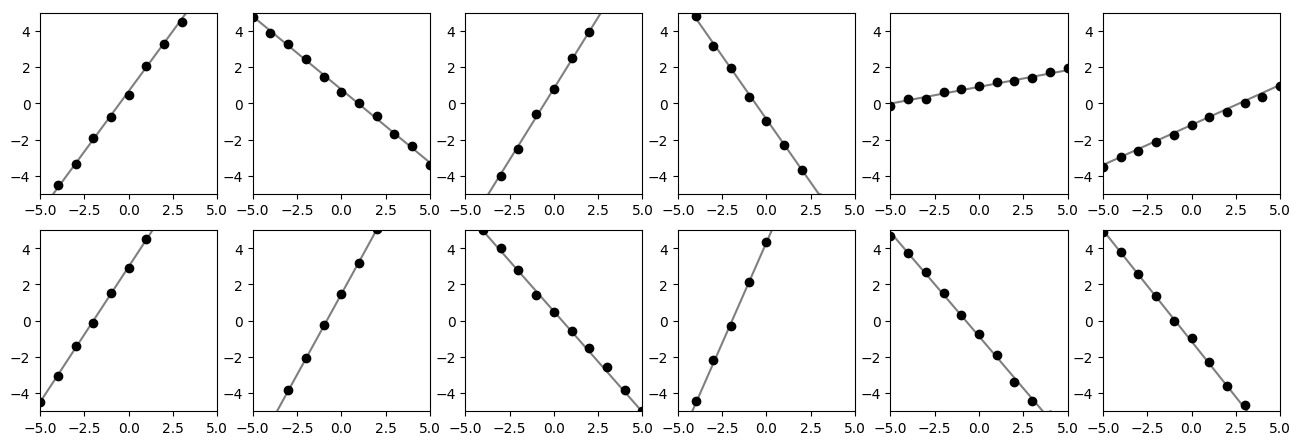

In [68]:
traces = [Gen.simulate(line_model, (xs,)) for _=1:12]
grid(render_trace, traces)

## 3. Doing Posterior inference  <a name="doing-inference"></a>

We now will provide a data set of y-coordinates and try to draw inferences about the process that generated the data. We begin with the following data set:

In [69]:
ys = [6.75003, 6.1568, 4.26414, 1.84894, 3.09686, 1.94026, 1.36411, -0.83959, -0.976, -1.93363, -2.91303];

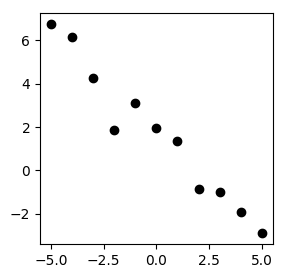

In [71]:
figure(figsize=(3,3))
scatter(xs, ys, color="black");

We will assume that the line model was responsible for generating the data, and infer values of the slope and intercept that explain the data.

Our simple *inference program* takes the model we are assuming generated our data, the data set, and the amount of computation to perform, and returns a trace that is approximately sampled from the _posterior distribution_ on traces of the function, given the observed data.

Functions like `importance_resampling` expect us to provide a _model_ and also an _choice map_ representing our data set and relating it to the model. A choice map maps random choice addresses from the model to values from our data set. Here, we want to tie model addresses like `(:y, 4)` to data set values like `ys[4]`:

In [72]:
function do_inference(model, xs, ys, amount_of_computation)
    
    # Create a choice map that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;

We can run the inference program to obtain a trace, and then visualize the result:

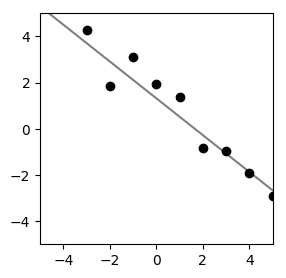

In [73]:
trace = do_inference(line_model, xs, ys, 100)
figure(figsize=(3,3))
render_trace(trace);

We see that `importance_resampling` found a reasonable slope and intercept to explain the data. We can also visualize many samples in a grid:

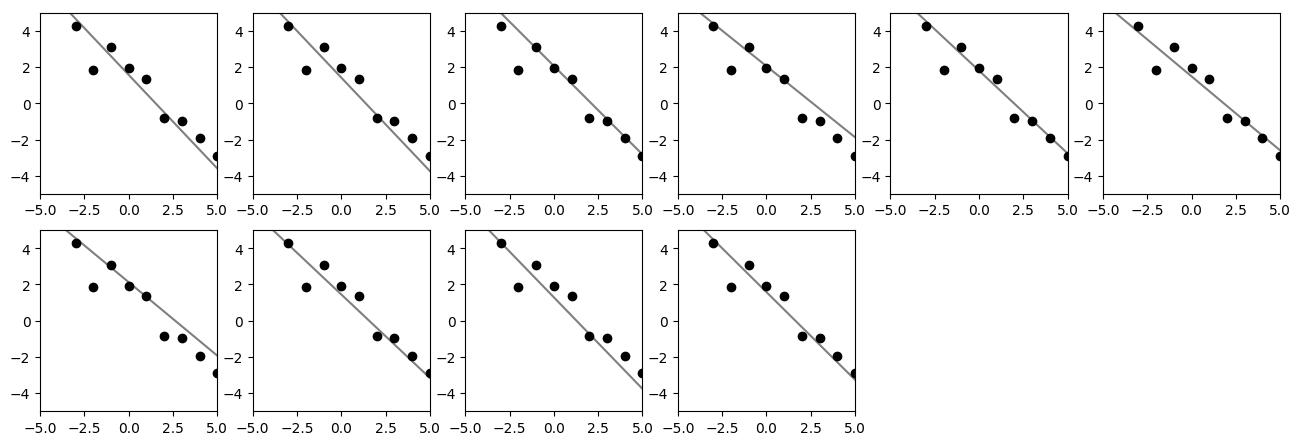

In [74]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
grid(render_trace, traces)

We can see here that there is some uncertainty: with our limited data, we can't be 100% sure exactly where the line is. We can get a better sense for the variability in the posterior distribution by visualizing all the traces in one plot, rather than in a grid.

In [77]:
function overlay(renderer, traces; same_data=true, args...)
    renderer(traces[1], show_data=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, args...)
    end
end;

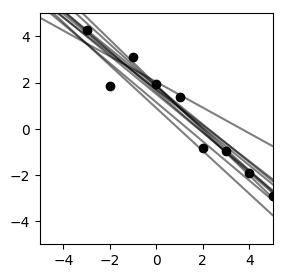

In [78]:
traces = [do_inference(line_model, xs, ys, 100) for _=1:10];
figure(figsize=(3,3))
overlay(render_trace, traces);

### Exercise

The results above were obtained for `amount_of_computation = 100`. Run the algorithm with this value set to `1`, `10`, and `1000`, etc.  Which value seems like a good tradeoff between accuracy and running time? Discuss.

## 4. Predicting new data  <a name="predicting-data"></a>

Using the API method [`generate`](https://probcomp.github.io/Gen/dev/ref/gfi/#Gen.generate), we can generate a trace of a generative function in which the values of certain random choices are constrained to given values.

For example:

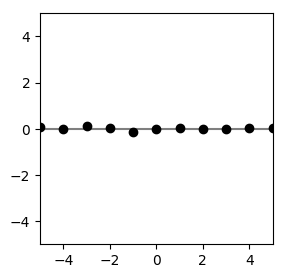

In [79]:
constraints = Gen.choicemap()
constraints[:slope] = 0.
constraints[:intercept] = 0.
(trace, _) = Gen.generate(line_model, (xs,), constraints)
figure(figsize=(3,3))
render_trace(trace);

We can use constraints to predict new data given inferred latents (e.g. inferred slope and intercept).

The function below (`predict_new_data`) takes a trace, and a vector of new x-coordinates, and returns a vector of predicted y-coordinates corresponding to the x-coordinates in `new_xs`. This function works with multiple models, so the set of parameter addresses is an argument (`param_addrs`):

In [80]:
function predict_new_data(model, trace, new_xs::Vector{Float64}, param_addrs)
    
    # Copy parameter values from the inferred trace (`trace`)
    # into a fresh set of constraints.
    constraints = Gen.choicemap()
    for addr in param_addrs
        constraints[addr] = trace[addr]
    end
    
    # Run the model with new x coordinates, and with parameters 
    # fixed to be the inferred values
    (new_trace, _) = Gen.generate(model, (new_xs,), constraints)
    
    # Pull out the y-values and return them
    ys = [new_trace[(:y, i)] for i=1:length(new_xs)]
    return ys
end;

The cell below defines a function that first performs inference on an observed data set `(xs, ys)`, and then runs `predict_new_data` to generate predicted y-coordinates. It repeats this process `num_traces` times, and returns a vector of the resulting y-coordinate vectors.

In [81]:
function infer_and_predict(model, xs, ys, new_xs, param_addrs, num_traces, amount_of_computation)
    pred_ys = []
    for i=1:num_traces
        trace = do_inference(model, xs, ys, amount_of_computation)
        push!(pred_ys, predict_new_data(model, trace, new_xs, param_addrs))
    end
    pred_ys
end;

Finally, we define a cell that plots the observed data set `(xs, ys)` as red dots, and the predicted data as small black dots.

In [82]:
function plot_predictions(xs, ys, new_xs, pred_ys)
    scatter(xs, ys, color="red")
    for pred_ys_single in pred_ys
        scatter(new_xs, pred_ys_single, color="black", s=1, alpha=0.3)
    end
end;

Recall the original dataset for the line model. The x-coordinates span the interval -5 to 5.

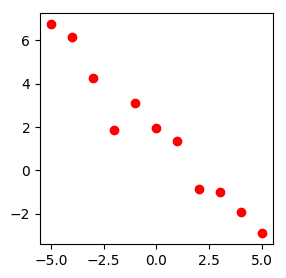

In [83]:
figure(figsize=(3,3))
scatter(xs, ys, color="red");

We will use the inferred values of the parameters to predict ys in the interval -5 to 10. Predicting new data from inferred parameters, and comparing this new data to the observed data is the core idea behind *posterior predictive checking*.

In [84]:
new_xs = collect(range(-5, stop=10, length=100));

We generate and plot the predicted data:

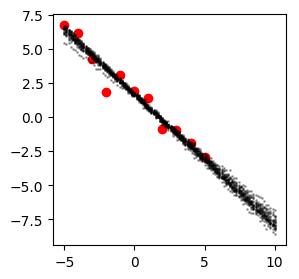

In [85]:
pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
figure(figsize=(3,3))
plot_predictions(xs, ys, new_xs, pred_ys)

The results look reasonable, both within the interval of observed data and in the extrapolated predictions on the right.

Now consider the same experiment run with following data set, which has significantly more noise.

In [86]:
ys_noisy = [5.092, 4.781, 2.46815, 1.23047, 0.903318, 1.11819, 2.10808, 1.09198, 0.0203789, -2.05068, 2.66031];

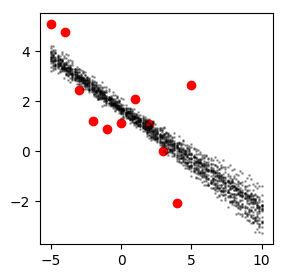

In [87]:
pred_ys = infer_and_predict(line_model, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1000)
figure(figsize=(3,3))
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

It looks like the generated data is less noisy than the observed data in the regime where data was observed, and it looks like the forecasted data is too overconfident. This is a sign that our model is mis-specified. In our case, this is because we have assumed that the noise has value 0.1. However, the actual noise in the data appears to be much larger. We can correct this by making the noise a random choice as well and inferring its value along with the other parameters.

### Exercise

Write a new version of the line model that samples a random choice for the noise from a `gamma(1, 1)` prior distribution.

In [89]:
@gen function line_model_2(xs::Vector{Float64})
    n = length(xs)
    slope = @trace(normal(0, 1), :slope)
    intercept = @trace(normal(0, 2), :intercept)
    
    # <your code here>
    
    for (i, x) in enumerate(xs)
        @trace(normal(slope * x + intercept, noise), (:y, i))
    end
    return nothing
end;

![Line Model with Noise](images/line_2.png)

Then, we compare the predictions using inference with the unmodified and modified model on the `ys` data set:

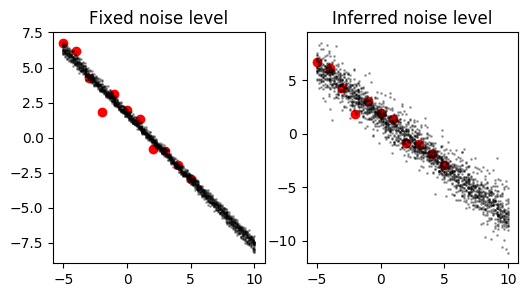

In [90]:
figure(figsize=(6,3))

pred_ys = infer_and_predict(line_model, xs, ys, new_xs, [:slope, :intercept], 20, 1000)
subplot(1, 2, 1)
title("Fixed noise level")
plot_predictions(xs, ys, new_xs, pred_ys)

pred_ys = infer_and_predict(line_model_2, xs, ys, new_xs, [:slope, :intercept, :noise], 20, 10000)
subplot(1, 2, 2)
title("Inferred noise level")
plot_predictions(xs, ys, new_xs, pred_ys)

Notice that there is more uncertainty in the predictions made using the modified model.

We also compare the predictions using inference the unmodified and modified model on the `ys_noisy` data set:

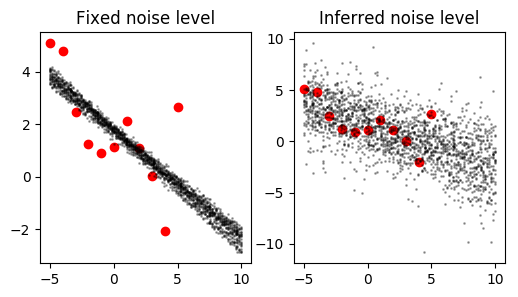

In [91]:
figure(figsize=(6,3))

pred_ys = infer_and_predict(line_model, xs, ys_noisy, new_xs, [:slope, :intercept], 20, 1000)
subplot(1, 2, 1)
title("Fixed noise level")
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

pred_ys = infer_and_predict(line_model_2, xs, ys_noisy, new_xs, [:slope, :intercept, :noise], 20, 10000)
subplot(1, 2, 2)
title("Inferred noise level")
plot_predictions(xs, ys_noisy, new_xs, pred_ys)

Notice that while the unmodified model was very overconfident, the modified model has an appropriate level of uncertainty, while still capturing the general negative trend.